In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# 예측해보기

In [ ]:
# 예측할 데이터 불러오기
predict_file_path = '/content/drive/MyDrive/skt/open/sample_submission.csv'
predict_df = pd.read_csv(predict_file_path)
predict_df.head()

,일시,평균기온
0,2023-01-01,0
1,2023-01-02,0
2,2023-01-03,0
3,2023-01-04,0
4,2023-01-05,0


# RNN

## RNN 실습

[ 주가예측 모델 신경망 ]

* 입력과 출력을 시퀀스 단위로 처리

  - 시퀀스란 문장 같은 단어가 나열된 것
  - 이러한 시퀀스들을 처리하기 위해 고안된 모델을 시퀀스 모델
  - 그중에서 RNN은 딥 러닝의 가장 기본적인 시퀀스 모델

* 은닉층에서 활성화 함수를 통해 결과를 내보내는 역할을 하는 노드를 셀
  - 이 셀은 이전의 값을 기억, 일종의 메모리 역할을 수행(메모리 셀)
  - 은닉층의 메모리 셀에서 나온 값이 다음 은닉층의 메모리 셀에 입력 ➔이 값을 은닉 상태


[금융 데이터 “ 거래소별 전체 종목 코드와 가격데이터”]

* Pandas-datareader : 시계열 데이터 수집 라이브러리

 - 금융 데이터를 다루는데 가장 기본이 되는 데이터는 거래소별 전체 종목 코드와 가격 데이터
  - pandas-datareader는 잘 구성된 시계열 데이터 수집 라이브러리로 사용이 간편하고 다양한 시계열 데이터를 수집할 수 있다는 장점
  - 거래소별(KRX, NASDAQ, NYSE 등)
  - 전체 종목 코드(ticker symbol)를 가져오는 기능이 없으며, 야후 파이낸스가 더 이상지원되지 않고(deprecated), 구글 파이낸스는 UNSTABLE_WARNING + RemoteDataError
  - FinanceDataReader는 pandas-datareader 를 대체하기 보다 보완하기 위한 목적

* Pandas-datareader 주요한 기능
  - 종목 코드
  - 거래소별 전체 종목코드:
  - KRX (KOSPI, KODAQ, KONEX), NASDAQ, NYSE, AMEX, S&P 500
  - 가격 데이터
  - 해외주식 가격 데이터: AAPL(애플), AMZN(아마존), GOOG(구글) 등
  - 국내주식 가격 데이터: 005930(삼성전자), 091990(셀트리온헬스케어) 등
  - 각종 지수: KS11(코스피지수), KQ11(코스닥지수), DJI(다우지수), IXIC(나스닥 지수), US500(S&P 5000)
 - 환율 데이터: USD/KRX (원달러 환율), USD/EUR(달러당 유로화 환율), CNY/KRW: 위엔화 원화 환율
  - 암호화폐 가격: BTC/USD (비트코인 달러 가격, Bitfinex), BTC/KRW (비트코인 원화 가격, 빗썸)





### FinanceDataReader로 주식 데이터 불러오기

In [ ]:
# 종목 코드 얻기
import pandas as pd
def make_code(x):
    x = str(x)
    return '0'*(6-len(x)) + x

code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download',header=0)[0]
code_data['종목코드'] = code_data['종목코드'].apply(make_code)
code_list = code_data[code_data['상장일'] < '2017-01-01']['종목코드']
code_data.head(15)

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,AJ네트웍스,095570,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,손삼달,http://www.ajnet.co.kr,서울특별시
1,BGF리테일,282330,종합 소매업,체인화 편의점,2017-12-08,12월,민승배,http://www.bgfretail.com,서울특별시
2,BNK금융지주,138930,기타 금융업,금융지주회사,2011-03-30,12월,빈대인,http://www.bnkfg.com,부산광역시
3,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
4,DS단석,017860,기타 화학제품 제조업,바이오에너지,2023-12-22,12월,한승욱,http://dsdansuk.com,경기도
5,HD한국조선해양,009540,기타 금융업,"선박,해양구조물,엔진,펌프 전동기,중전기,중장비 제조/자동창고,물류시스템",1999-08-24,12월,"가삼현, 정기선 (각자 대표이사)",http://www.ksoe.co.kr,경기도
6,HD현대에너지솔루션,322000,반도체 제조업,"태양광 셀·모듈, PV시스템, ESS",2019-11-19,12월,박종환,http://www.hd-hyundaies.co.kr,경기도
7,KG케미칼,001390,기초 화학물질 제조업,"콘크리트혼화제, 비료, 친환경농자재, 수처리제",1989-08-25,12월,"곽정현, 김재익",http://www.kgchem.co.kr,울산광역시
8,KH 필룩스,033180,전자부품 제조업,"전자부품(페라이트코아,트랜스포머,데코램프) 제조/온라인정보 제공/부동산 임대",2001-12-26,12월,배보성,http://www.feelux.com,경기도
9,KPX케미칼,025000,기초 화학물질 제조업,"PPG,PU RESIN,우레탄수지,대향막박리재,반도체 CM PAD,Polyether...",1994-12-27,12월,"양준영, 최재호, 이찬수(각자대표이사)",http://www.kpxchemical.com,서울특별시


한국 거래소에서 크롤링해온 엑셀 파일이어서 csv로 저장하여 이후에도 동일한 데이터로 사용하기

In [ ]:
# Save code_data to a CSV file
code_data.to_csv('/content/drive/MyDrive/skt/code_data.csv', index=False)

# Read the CSV file back into a DataFrame
code_data = pd.read_csv('/content/drive/MyDrive/skt/code_data.csv')

# Display the first few rows of the saved DataFrame
code_data.head()


,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,AJ네트웍스,95570,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,손삼달,http://www.ajnet.co.kr,서울특별시
1,BGF리테일,282330,종합 소매업,체인화 편의점,2017-12-08,12월,민승배,http://www.bgfretail.com,서울특별시
2,BNK금융지주,138930,기타 금융업,금융지주회사,2011-03-30,12월,빈대인,http://www.bnkfg.com,부산광역시
3,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
4,DS단석,17860,기타 화학제품 제조업,바이오에너지,2023-12-22,12월,한승욱,http://dsdansuk.com,경기도


In [ ]:
!pip install finance-datareader

In [ ]:
# 특정 종목 불러오기
# DL 종목 15~17년 데이터
import FinanceDataReader as fdr
# fdr.DataReader( symbol = 종목명, start = 시작 날짜, end = 종료 날짜)로 불러옵니다.
# LG헬로비전
fdr.DataReader('037560', start = '2015', end = '2017')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2015-01-02,12023,12072,11826,11826,204614,-0.012360
2015-01-05,11814,11961,11199,11912,276056,0.007272
2015-01-06,11826,11924,11592,11679,186655,-0.019560
2015-01-07,11580,11666,11433,11433,167954,-0.021063
2015-01-08,11433,11482,11285,11347,305679,-0.007522
...,...,...,...,...,...,...
2016-12-23,8990,9290,8940,9280,119582,0.039194
2016-12-26,9390,9390,9260,9260,106610,-0.002155
2016-12-27,9270,9280,9140,9200,92151,-0.006479


### FinanceDataReader 특징

* '000210' DL이라는 회사의 15년부터 현재까지의 데이터입니다.

- Date 주식시장 개장 날짜

- Open은 해당 개장일의 시가

- High는 해당 개장일의 고가

- Low는 해당 개장일의 저가

- Close는 해당 개장일의 종가

- Volume은 해당 개장일의 거래량

- Change는 해당 개장일의 전날 대비 종가 상승률 입니다. (음수면 하락 양수면 상승)

In [ ]:
#fdr.DataReader('000210', start = '2015' ).reset_index()

### LG헬로비전 시각화

In [ ]:
!pip install yfinance

[*********************100%%**********************]  1 of 1 completed


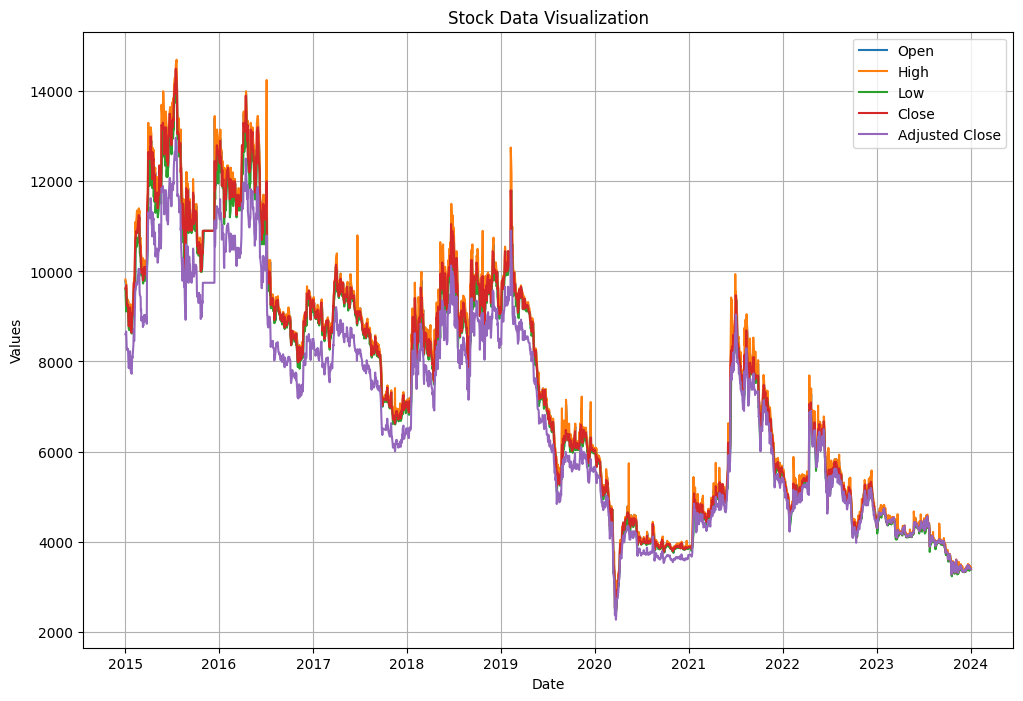

In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Fetch data using yfinance
df = yf.download('037560.KS', start='2015-01-01').reset_index()

# Plotting
plt.figure(figsize=(12, 8))

# Plot each column
plt.plot(df['Date'], df['Open'], label='Open')
plt.plot(df['Date'], df['High'], label='High')
plt.plot(df['Date'], df['Low'], label='Low')
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['Adj Close'], label='Adjusted Close')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Stock Data Visualization')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


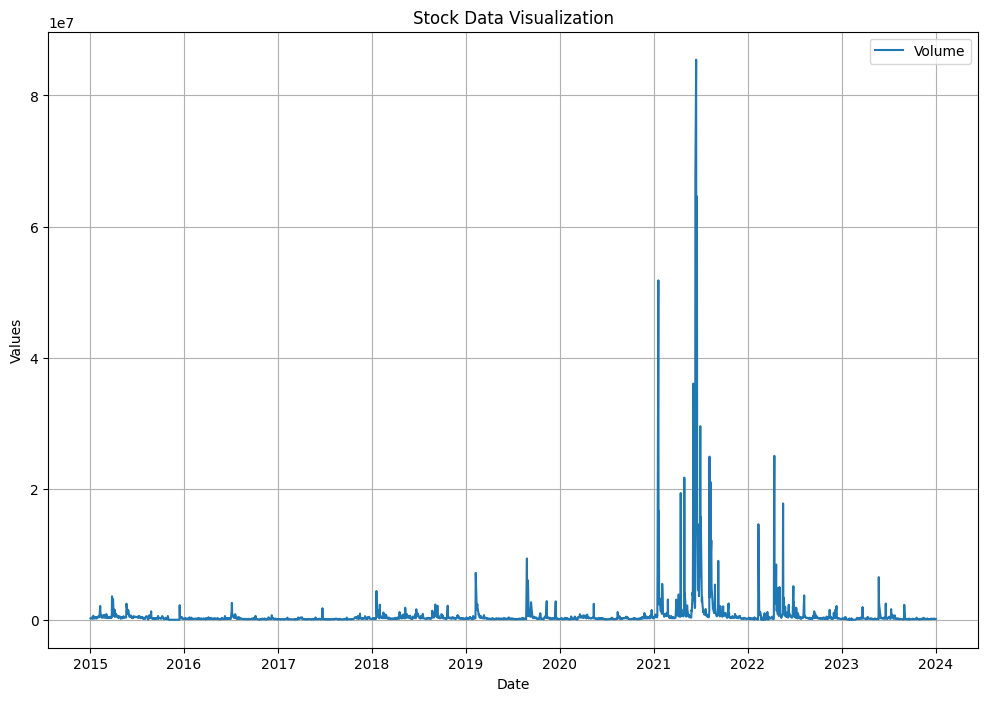

In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Fetch data using yfinance
df = yf.download('037560.KS', start='2015-01-01').reset_index()

# Plotting
plt.figure(figsize=(12, 8))

# Plot each column

plt.plot(df['Date'], df['Volume'], label='Volume')


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Stock Data Visualization')
plt.legend()
plt.grid(True)
plt.show()


### LG헬로비전 2021년도에 거래량이 높아져서 무슨 일이 있었나 검색해 본 결과

* LG헬로비전, 2021년 영업익 445억원 달성... 전년비 103억 증가

- https://biz.newdaily.co.kr/site/data/html/2022/01/26/2022012600228.html
- "연간으로는 영업수익이 전년 대비 222억, 영업이익이 103억 증가했다. LG헬로비전은 영업이익 증가에 대해 비용절감을 통한 수익성 강화, 미디어∙렌탈 등 기타수익 부문 성장에 따른 결과라고 설명했다."


- 현재는 쭉쭉 내려가는 중

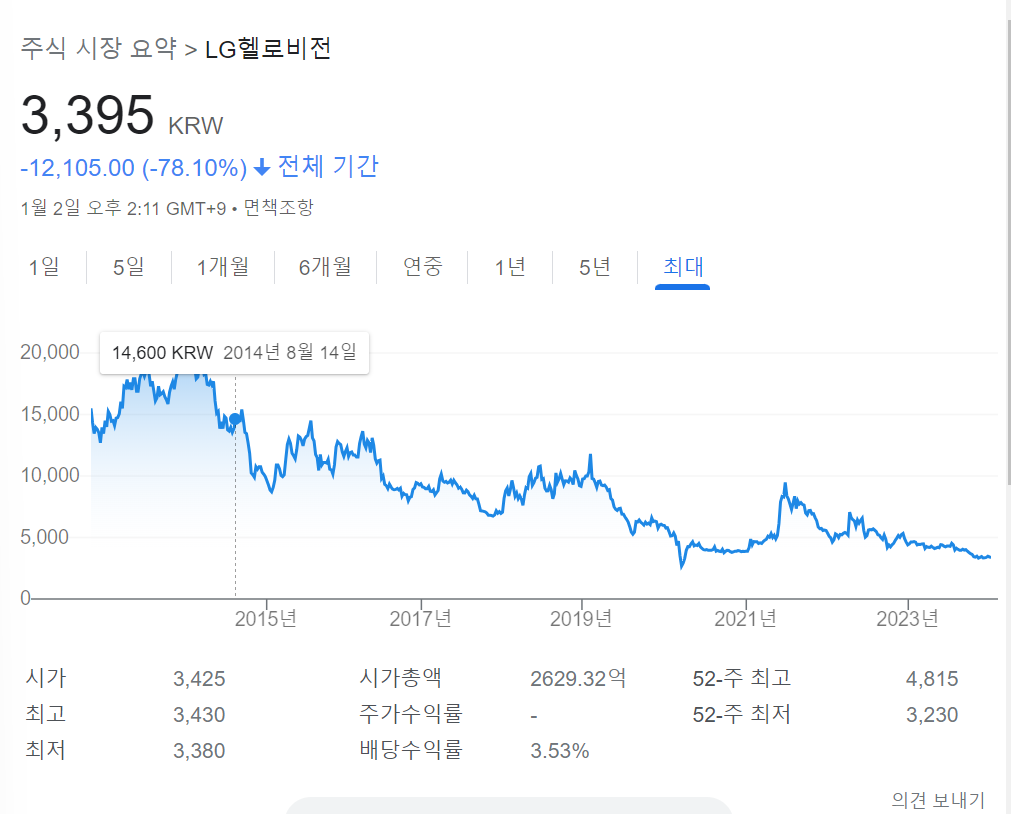

### 모델 만들기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
# 주식 데이터 불러오기
df = fdr.DataReader('037560', start='2015', end='2023')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-12-23,4730,4730,4610,4620,176722,-0.035491
2022-12-26,4655,4655,4540,4590,113714,-0.006494
2022-12-27,4580,4625,4570,4590,138704,0.000000
2022-12-28,4505,4550,4480,4480,127537,-0.023965
2022-12-29,4480,4495,4400,4400,130435,-0.017857


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1969 entries, 2015-01-02 to 2022-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1969 non-null   int64  
 1   High    1969 non-null   int64  
 2   Low     1969 non-null   int64  
 3   Close   1969 non-null   int64  
 4   Volume  1969 non-null   int64  
 5   Change  1969 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 107.7 KB


In [ ]:
df.shape

(1969, 6)

In [ ]:
# 결측치 확인
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

In [ ]:
# 선택할 특성들
selected_features = ['Open', 'High', 'Low', 'Close', 'Volume']

# 선택한 특성들만 추출
data = df[selected_features].values


In [ ]:
# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [ ]:

# 데이터를 시퀀스로 변환
sequence_length = 10  # 시퀀스 길이 설정
sequences = []
targets = []

In [ ]:



for i in range(len(data_scaled) - sequence_length):
    sequence = data_scaled[i:i+sequence_length]
    target = data_scaled[i+sequence_length]
    sequences.append(sequence)
    targets.append(target)

# Numpy 배열로 변환
sequences = np.array(sequences)
targets = np.array(targets)

In [ ]:
# 훈련 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.3, random_state=42)


In [ ]:
# RNN 모델 구축
model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', input_shape=(sequence_length, len(selected_features))))
model.add(Dense(units=len(selected_features), activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 모델 훈련
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
43/43 [==============================] - 4s 17ms/step - loss: 0.0613 - val_loss: 0.0080
Epoch 2/50
43/43 [==============================] - 1s 26ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 3/50
43/43 [==============================] - 1s 25ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/50
43/43 [==============================] - 2s 36ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 5/50
43/43 [==============================] - 1s 23ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 6/50
43/43 [==============================] - 1s 27ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 7/50
43/43 [==============================] - 1s 25ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 8/50
43/43 [==============================] - 1s 22ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/50
43/43 [==============================] - 1s 24ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/50
43/43 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 11/

In [ ]:

# 예측
predictions = model.predict(X_test)


19/19 [==============================] - 0s 3ms/step


In [ ]:
# 원래 스케일로 복원
predictions_original = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)


In [ ]:
# 평가 지표 계산
mse = mean_squared_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)

In [ ]:
# 결과 출력
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 4281161508125.9326
R-squared (R2): 0.7717686569431749


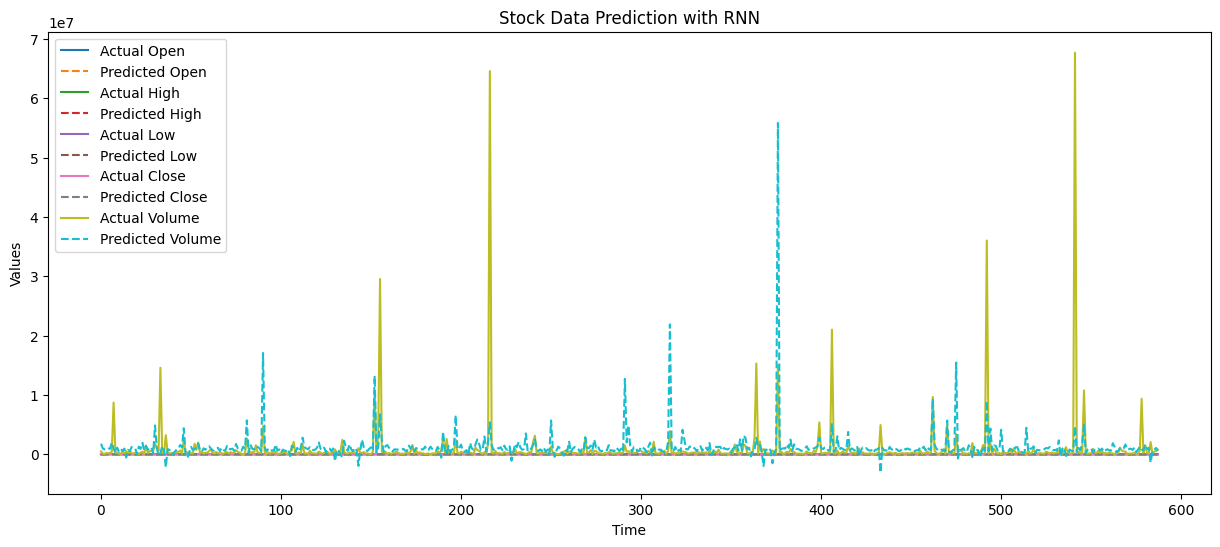

In [ ]:
# 시각화
plt.figure(figsize=(15, 6))
for i, feature in enumerate(selected_features):
    plt.plot(y_test_original[:, i], label=f'Actual {feature}')
    plt.plot(predictions_original[:, i], label=f'Predicted {feature}', linestyle='dashed')

plt.title('Stock Data Prediction with RNN')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

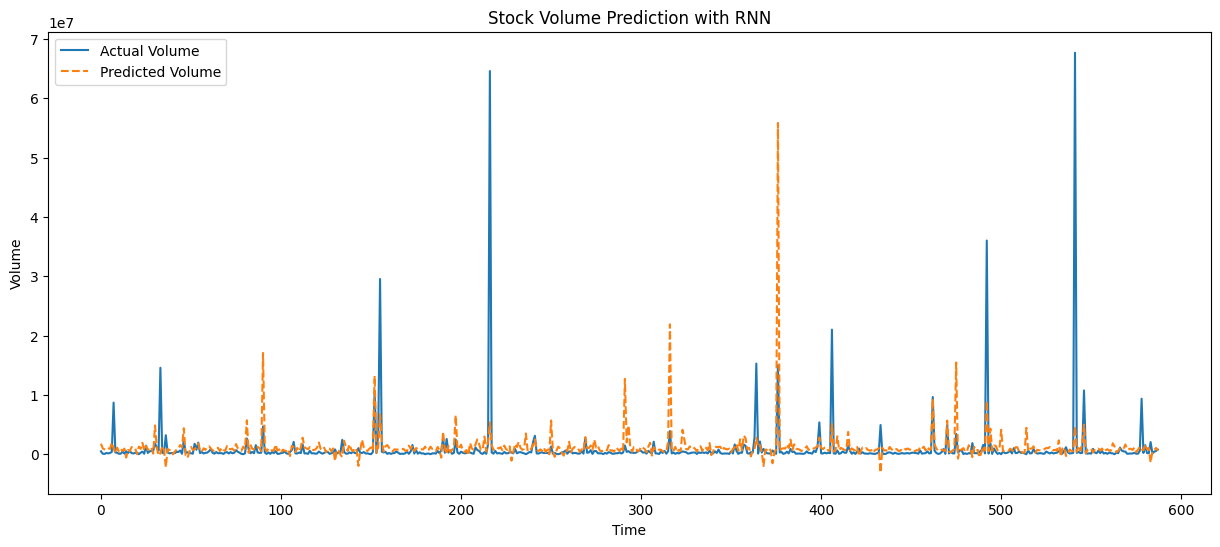

In [ ]:
# 시각화 (Volume만)
plt.figure(figsize=(15, 6))
plt.plot(y_test_original[:, -1], label='Actual Volume')
plt.plot(predictions_original[:, -1], label='Predicted Volume', linestyle='dashed')

plt.title('Stock Volume Prediction with RNN')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()

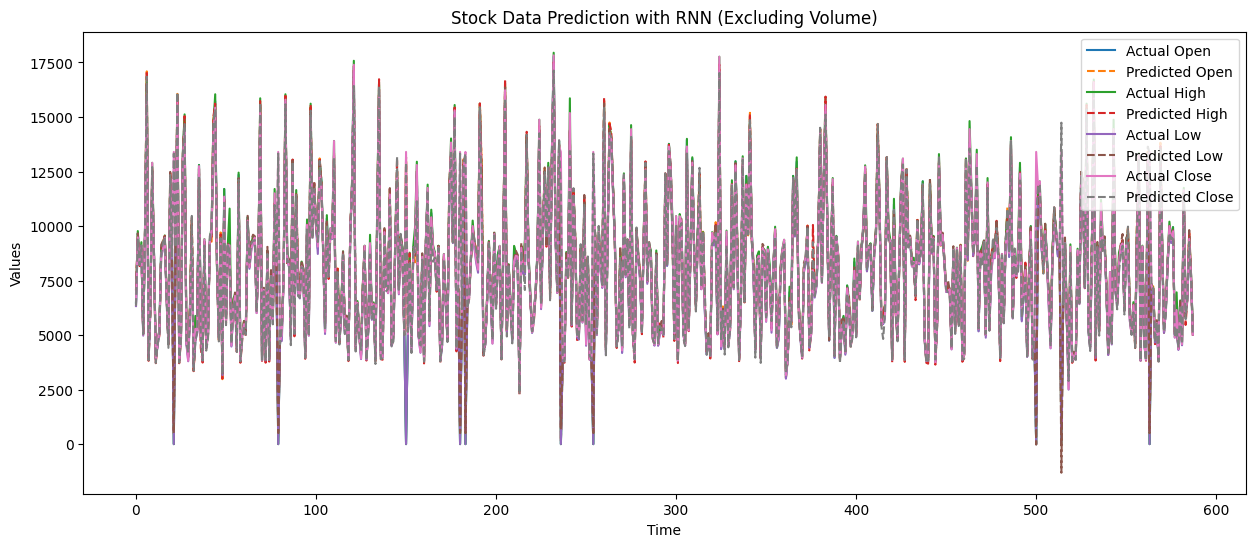

In [ ]:
# 시각화 (Volume을 제외한 항목들)
plt.figure(figsize=(15, 6))
for i, feature in enumerate(selected_features[:-1]):  # Volume을 제외한 항목들만 선택
    plt.plot(y_test_original[:, i], label=f'Actual {feature}')
    plt.plot(predictions_original[:, i], label=f'Predicted {feature}', linestyle='dashed')

plt.title('Stock Data Prediction with RNN (Excluding Volume)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


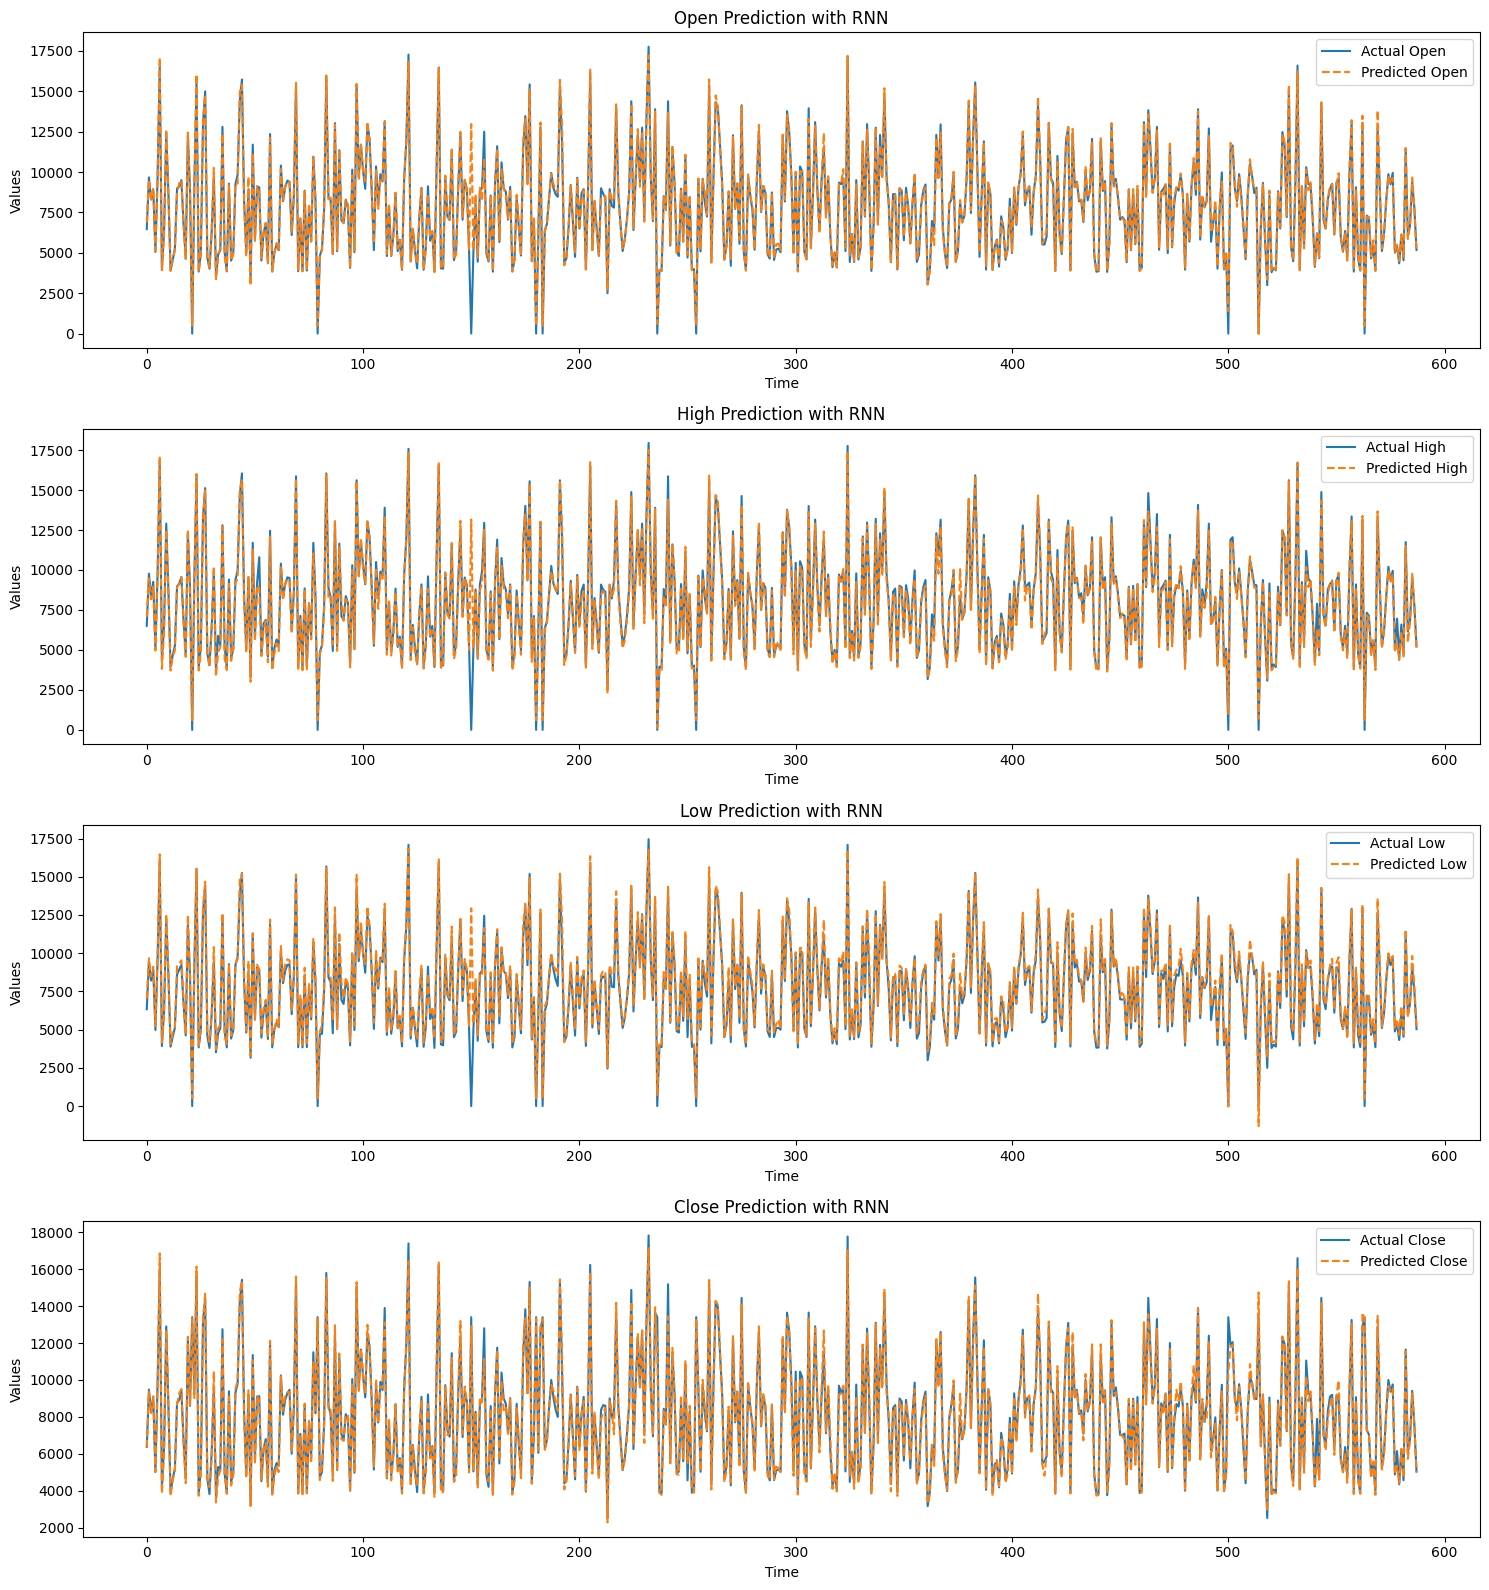

In [ ]:
# 시각화 (각 항목별로 subplot으로 그리기)
num_features = len(selected_features) - 1  # Volume을 제외한 항목의 개수

plt.figure(figsize=(15, 4 * num_features))

for i, feature in enumerate(selected_features[:-1]):  # Volume을 제외한 항목들만 선택
    plt.subplot(num_features, 1, i + 1)
    plt.plot(y_test_original[:, i], label=f'Actual {feature}')
    plt.plot(predictions_original[:, i], label=f'Predicted {feature}', linestyle='dashed')
    plt.title(f'{feature} Prediction with RNN')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()

plt.tight_layout()
plt.show()
